# Real estate consulting 

Group Number: 32

Members:

- Manan Saddi (Student ID: 1353292)
- Jeremy Lau (Student ID:1356056)
- Kevin Tang (Student ID: 1080171)
- Daniel Nappa (Student ID: 1170717)

The summary book has the following topics:

- Data Scraping 
- The preprocessing 
- The features aggregation and engineering
- Property Data Analysis (EDA)
- The Model (Forecasting Rental Prices)
    - Ridge regression
    - Random forrest
    - XGboost 
- Most Important Factors Affecting Rent
- Livability Scoring
- The Limitations and the Assumptions 

In [13]:
# Libraries required to run the notebook
import pandas as pd
from folium import Figure
from PIL import Image

## `Data Scraping`

`scripts\domain_scraper.py` is the main scraping script, upon execution, the user is prompted with a menu outputted to the console to select which steps of scraping to perform, from either the data sources of `domain.com.au` (rental listing data for testing) or `auhouseprices.com` (historical rental listings for training). 

The `DomainScraper` class in `scripts\domain_scraper.py` is designed to scrape rental listings from the domain.com.au website for rental property listings in Victoria, Australia. The scraper utilizes several Python libraries to enhance its functionality and performance. 
 - `requests` is used for making HTTP requests to fetch the web pages, while `json` is used to parse the JSON responses. 
 - To greatly increase the scraping rate, `threading`  is used, allowing the scraper to process multiple pages concurrently, significantly speeding up the scraping process. 
 - `numpy` is used to partition the list of pages into smaller chunks, of which each partition is then delegated to a single thread. 
 - The `rich` library is utilized to display a progress bar in the console, providing real-time feedback on the scraping progress. 
 - For the procedure of scraping the Victorian Rental Listings, the `DomainScraper` uses a stack to implement a depth-first search (DFS) to traverse property listings from suggested property listings of a given listing, through each page to get all rental listings for Victoria. This approach ensures that all possible related listings are explored thoroughly.
 - The scraper handles previously visited URLs and collisions, ensuring that each listing is processed only once.
 - The scraper conducts a myriad of sanity checks upon receiving a `.json` response, such as ensuring the necessary `.json` fields exist, are populated, and contain certain values, for example, ensuring the currently visited property listing is actually in Victoria. Otherwise, the scraper skips the listing. 
 - The scraper makes requests for a given listing to `domain.com.au` with `application\json` as the requested encoding for the `Accept` and `Content-Type` headers. This was discovered as all rental listing URLs have an equivalent `.json` encoding to their `.html` counterparts, improving the convenience of parsing data. 
 - The number of threads used for scraping may need to be adjusted to a lower pool size by reducing the number of partitions, to account for IP blocking when scraping from `domain.com.au`
 - All scraped `.json` files are named corresponding to the property ID determined by Domain, and successfully scraped `.json` files are stored in the `landing` layer. 

The `AuHousePricesScraper` class in `scripts/auhouseprices_scraper.py` is designed to scrape property data from the `auhouseprices.com`, focusing on rental listings in Victoria. This scraper is built to handle the large database of rental listings from `auhouseprices.com` through a combination of asynchronous requests, multiprocessing, and error handling mechanisms.

- **Initial Setup**: The scraper starts by setting up directories for storing raw and landing data if they do not already exist. It ensures the necessary folders exist before proceeding with any scraping or data storage operations.

- **Sitemap Parsing**: The scraper first retrieves and parses the website's sitemap XML file, specifically focusing on URLs related to Victorian rental listings. This step is crucial as it allows the scraper to gather all relevant URLs in a single pass without having to perform an exhaustive search on the website, reducing load on the host server.

- **Async HTTP Requests**: For the actual scraping process, `asyncio` is used to manage asynchronous tasks, allowing multiple HTTP requests to be made concurrently. The `aiohttp` library handles these requests, fetching the HTML content of each rental listing. This approach speeds up the scraping process significantly by avoiding the blocking nature of traditional synchronous requests, by using a different proxy session for each asynchronous task delegated to a partition of rental listing URLS.

- **Proxy Management**: To handle potential IP blocking, the scraper incorporates proxy management via the `get_proxy_url_brightdata` function, which rotates proxy sessions dynamically. This ensures the scraper can continue operating without being blocked by the host server, especially when dealing with large numbers of requests.

- **Storing HTML Files**: Once the HTML content for each listing is retrieved, it is saved as a `.html` file in the `landing` layer. These files serve as the raw data that will later be parsed and processed.

- **Preprocessing of HTML Files**: In the next phase, the user can choose to preprocess the scraped `.html` files. This step involves parsing the HTML to extract structured data (e.g., property type, address, rent, etc.). The preprocessing is a CPU-bound task, which is why 1multiprocessing` is employed here to speed up the parsing process. 

- **Multiprocessing for Parsing**: This is where the heavy lifting occurs, as the raw HTML data is parsed and processed. Since this is a CPU-bound task, `multiprocessing` is employed to parallelize the workload across multiple CPU cores. This improves performance when processing the large number of saved HTML files, converting them into structured datasets. By splitting the list of `.html` files into partitions, each partition is assigned to a separate process for parsing. This parallelization ensures efficient use of CPU resources, significantly reducing the time needed for preprocessing a large amount of rental listings. 

- **Progress Tracking**: Throughout both the scraping and parsing stages, the `rich` library is used to provide visual feedback to the user. Progress bars are displayed in the console, indicating the number of listings processed and giving real-time updates on the overall progress.

- **Error Handling and Retries**: The scraper includes mechanisms to handle errors, such as failed requests or missing data fields. It also handles retries when requests fail or proxies become unavailable. Additionally, erroneous listings are flagged and logged for re-scraping, ensuring that no data is lost or skipped.

- **Storing Parsed Data**: Once the HTML files have been processed, the extracted data is stored in CSV files in the `raw` layer. These files contain structured information such as property type, rent, address, geographic coordinates, and other relevant details.

- **Handling Extra URLs and Erroneous Files**: The scraper also identifies additional URLs for related listings and attempts to re-scrape erroneous listings. It compares the checksums of re-scraped files with the originals to ensure data integrity.

This organized, asynchronous, and multiprocessing-based approach allows for efficient scraping and parsing of rental listings on auhouseprices.com, ensuring that data is collected and processed quickly and accurately.

- The historical domain dataset (from `auhouseprices.com`): Listings obtained by scraping, this dataset was used to conduct the EDA as well as the modelling
    ..this dataset contained columnn such as: 

    - **unique_id** (Int64): Unique identifier for the property.
    - **street_name** (String): Name of the street where the property is located.
    - **state** (String): The state in which the property is located.
    - **postcode** (Int64): Postcode of the property's location.
    - **suburb** (String): Suburb in which the property is located.
    - **property_type** (String): Type of the property (e.g., house, apartment).
    - **address** (String): Full address of the property.
    - **rent** (Float64): Rent amount for the property.
    - **num_bedrooms** (Int64): Number of bedrooms in the property.
    - **num_bathrooms** (Int64): Number of bathrooms in the property.
    - **parking** (Int64): Number of parking spaces available for the property.
    - **distance_to_cbd** (Float64): Distance from the property to the Central Business District (CBD) in kilometers.
    - **sold_date** (String): Date when the property was sold.
    - **latitude** (Float64): Latitude coordinate of the property.
    - **longitude** (Float64): Longitude coordinate of the property.

- The Domain dataset: Listings obtained by scraping the domain website, this dataset was used in conjunction to the historical dataset to conduct the EDA and the modelling. The columns used for this dataset were the same as the historical datase t(hence they were merged).

- The School scoring by suburbs dataset: (Kevin)

- The LGA population dataset: (Kevin)

- The LGA crime dataset: (Kevin)

- The Suburb to LGA : This Dataset maps the suburbs to its matching LGA

- The SA2 Dataset: This contains the geometries of the SA2 areas.

- The Suburb dataset: This is suburb mappings contains the gemetry for the suburbs in victoria.

- The Station dataset: This contains the information on the train stops and there geometries.





## `Preprocessing`

### Main Internal Factors Included 


- The Type of propeties
- The number of bedrooms 
- The number of bathrooms 
- The car parking spaces on the property 
- The Longitude/Latitude of the property
- Suburb the property resides in 

### Main External Factors Included 


- The distance to the CBD per property
- The distance to the closest train station
- The Suburb's number of education centres/primrary schools and the number of high scoring highschools(assumption : we considered the VCAA percentage of per school 40+ study score to rank the school as it, in way encapsulates the schools quality)
- The population density of the LGA(local government area), it was used as a way to estimate the population density of suburb(assumption : the population density of suburb ~ the population density)
- The crime density of the LGA(local government area), it was used as a way to estimate the crime density of suburb(assumption : the crime density of suburb ~ the crime  density)



### Preprocessing the `domain.com.au` Datasets and the historical (`auhouseprices.com`) dataset

- We made sure that the rent/bedroom/bathrooms and etc., columns that were meant to be positive, have all there values be positive(the non-positive values were rooted)
- We made sure that the rows with empty catigorical values(property type,suburbs and etc) were removed to maintain the quality of the data 
- the column names were made identical for both the datasets to be merged(Domain dataset and the historical dataset)
- the categorical values for these rent properties were converted to lowercase
- the invalid longitude and latitude for the rented properties were discarded(for example the longititude and latitude was 0 for some rows which is invalid)
- the properties not in victoria were disincluded as well since we are assessing the rental prices in victoria, and have=ing those data points would taint our research topic 
- (limitation) properties before 2015 were elinimated, since we were not able to find crime data before 2015, and precasting would have bought in unnecessary complexity 
- there properties that did not count as homes(for example warehouse and land), so we decided to dispose those rows to preserve our research topic 

these tasks were completed in:

`/notebooks/preprocess_doman_listings.ipynb`
and
`/notebooks/preprocess_auhouseprices_listings.ipynb`

### Preprocessing Population & Crime

- Completed in: `/notebooks/preprocess_pop_and_crime.ipynb`
- Population data from 2013 to 2023
- Extracted rate crime rate per 100,000 population
- Limitation & Assumptions
    - The location for both population and crime data are by LGA, since our granularity for rental forecast is by suburbs,  we used `/notebooks/preprocess_suburb_lga_convert.ipynb` to map LGAs to suburbs.
    - Since the population is only up to 2023 and we wish to also anlysis data for 2024, we used ARIMA to forecast the data for 2024, with an MAE accuracy of 7,196.67 means that, meaning the model’s population predictions were off by around 7,197 people per LGA.

### Preprocessing Schools

- Data from Victorian Government, consists of all primary, secondary schools, as well as other education centres.
- Completed in: `/notebooks/preprocess_schools.ipynb`
- As shown in table below, we counted the number of schools in each suburb by school type & school exam performance
- School Type: 
    1. primary schools
    2. secondary schools (public, private, catholic)
    3. education centres
- School Performance based on percentage of students scoring VCE study score 40 and over
    - Very High VCAA (VCE Exam Result): more than 15%
    - Great Scoring: 10%-15%
    - Good Scoring: 4.5%-9.5%

In [9]:
file_path = '../data/curated/schools_preprocessed.csv'
df = pd.read_csv(file_path)
df.head() 

,Unnamed: 0,suburb,num_primary,num_secondary_public,num_secondary_private,num_secondary_catholic,num_edu_centre,v_high_vcaa,high_vcaa,good_vcaa
0,0,abbotsford,2,0,1,0,0,0.0,0.0,0.0
1,1,aberfeldie,1,0,0,1,0,0.0,0.0,1.0
2,2,aintree,1,0,0,0,0,0.0,0.0,0.0
3,3,aireys inlet,1,0,0,0,0,0.0,0.0,0.0
4,4,airly,1,0,0,0,0,0.0,0.0,0.0


- Limitations & Assumptions
    - The count for each suburb does not take nearby suburbs into account, future studies could implement proximity to schools for each property
    - Although the scoring provides a generally accurate representation of the school's academic reputation, the percentage cut-off between top scoring and great scoring schools may not be strictly accurate, and factors like extra-curricular activities may also play a role in school's reputation and education quality; in addition, we could also potentially look for data like enrolment, school transfer, surveys to provide a better representation of school reputatuion

### Outlier analysis

it can be seen below that the rental properties, summary below migh be unreasonable as the property with the maximum number of bedrooms has 650 bedrooms and the most expensive property has an absurdly high rent, hence for the domain and the historical data we required outlier removal, not removing these outliers would leed to innacurate models and analysis.

![Getting Started](../plots/Screenshot%202024-10-07%20at%208.45.45 PM.png)


<!-- 'Screenshot 2024-10-07 at 8.45.45 PM.png' -->

To deal with the outliers we eliminated the top percentile of the results mosly, since there were a lot of absurdly high values. in the data we have disposed of a lot of the feature's  above ~99.99 percentile data.

bellow is the code used to achieve this result 

Asummption/limitation : the quantiles we chose were arbitrary, hence might have lead to overfitting



The following visualization helps in understanding the distribution of rental properties and identifying potential outliers:

![code outlier analysis](../plots/outlierAfter.png)

<!-- 'Screenshot 2024-10-07 at 9.51.06 PM.png' -->

after the taking out the outliers the values of the continous variables become a lot more feasable for a normal houses rent. as seen below...

The following visualization helps in understanding the distribution of rental properties and identifying potential outliers:


![Outlier Analysis](../plots/outlierdataafter.png)

<!-- 'Screenshot 2024-10-07 at 9.51.06 PM.png' -->

There was no outlier analysis needed from the other datasets since they were mostly secure, and since most of them were found on the government websites and diposing outlier values would have lead to inaccuracy...

furthermore the code for preprocessing can be found in `/notebooks/preprocess_doman_listings.ipynb` and `/notebooks/preprocess_auhouseprices_listings.ipynb`

### Feature agregation and Merging

- the date column of the property was sepereated into month and year, as it was assumed there would be a trend between year vs rent and month vs year 
- the coordinates for the house in conjunction with the station data to find the line distance to the closest station(this was made into another columns)
- we decided to change the property types given to us, for example since flat,appartments and units were similar properties and had similar prices we decided to group them toghether(by renaming them to `Apartment / Unit / Flat`)
- the school data(as described) was attached to the propeties based on suburbs for each property(Assumption: suburbs that were not present in the schools data were assumed to have 0 schools, 0 high scoring schools and ect.)
- The property types were encoded as one hot key, as we felt from our analysis that they were an important feature in deciding prices...
- The LGA dataset was used to map the suburbs to there respective LGA, furter this was used to attach the LGA crime density and LGA population density to there respective suburb properties, the rows for which the LGA were not found were rooted to preserve data integrity, since their property Longitudes and Latitude did not match their suburb location(a lot of the time they were outside victoria).

(assumption) Suburb statistics (population, crime) assumed to be similar to their LGA to capture surrounding information.


(limitaion) We attempted to use Open route service API to obtain the route distance to the closest station(and the cbd) as a more realistic metric than line distance, however since the API only permited a limited number of distance requests per day(2500 on our plan), finding the closest station would not have been feasable for the 450k rows of data we had after preprocessing, even hosting our own servers there were a limited number of calls, we decided to go with the line distance ...

Feature aggregation was done at `/notebooks/preprocess_auhouseprices_listings.ipynb` and `/notebooks/featureagg_oldhouse.ipynb`

After the preprocessing and merging the main dataset went from  `~900k` rows  ---> `~484k` rows  

In [10]:
import pandas as pd

df_final = pd.read_csv('../data/curated/forcast_dataset.csv')
df_final


,suburb,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,latitude,longitude,nearst_train_station_dist,year,...,property_type_house,property_type_retirement living,property_type_serviced apartment,property_type_studio,property_type_townhouse,property_type_villa,lga,Year,"Rate per 100,000 population",lga_population
0,melton west,449.0,4.0,2.0,2.0,39.400000,-37.664852,144.556370,15.035350,2015,...,True,False,False,False,False,False,melton,2015.0,7518.066931,134915.000000
1,southbank,585.0,2.0,2.0,1.0,1.560000,-37.827305,144.959050,1.219429,2015,...,False,False,False,False,False,False,melbourne,2015.0,25240.370565,136872.000000
2,rowville,390.0,3.0,1.0,2.0,26.460000,-37.920490,145.232380,7.008687,2015,...,True,False,False,False,False,False,knox,2015.0,6145.557656,158700.000000
3,springvale,400.0,4.0,2.0,1.0,21.750000,-37.940765,145.151440,0.985106,2015,...,True,False,False,False,False,False,greater dandenong,2015.0,11086.049686,156061.000000
4,ballarat east,290.0,3.0,1.0,1.0,98.350000,-37.568535,143.889040,73.684221,2015,...,False,False,False,False,False,False,ballarat,2015.0,10860.375053,101479.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484553,burwood east,1050.0,4.0,3.0,2.0,15.825365,-37.856688,145.132631,2.098144,2023,...,False,False,False,False,True,False,whitehorse,2023.0,4950.206842,178639.000000
484554,werribee south,560.0,4.0,2.0,2.0,28.143669,-37.963369,144.707632,8.197645,2022,...,True,False,False,False,False,False,wyndham,2022.0,5270.557664,309398.000000
484555,ferntree gully,700.0,3.0,2.0,2.0,28.016795,-37.882581,145.267643,2.431007,2022,...,False,False,False,False,False,False,knox,2022.0,5691.041624,159549.000000
484556,coburg,835.0,3.0,3.0,2.0,8.289849,-37.737269,144.982527,1.594189,2024,...,False,False,False,False,True,False,darebin,2024.0,9172.670623,155788.090972


### Feature engeering for the Forcasting

In the modelling part to take the essence of each suburb with without increasing dimensionality in our models:

- made a seperate column representing the average distance of a house from a singular suburb to the cbd
- made a seperate column representing the average rent of a house from a singular suburb, from 2015 to 2020

these steps were taken to ensure we did not have to use one hot key, since we had hundreds of suburbs to consider this would have incurred the curse of dimensionality, in consequence decreasing the quality of the model 

## `EDA`

One interesting finding from the data is that there is a sharp rise from properties with 4 bedrooms to 5 bedrooms and not much increase afterwards, as shown in the graph below. Possible reasons include bedrooms loses its significance in property value in large properties as many may opt for entertainment rooms instead of building more bedrooms, a second possible reason would be not enough data for higher bedroom properties as they are not as common in the market. 

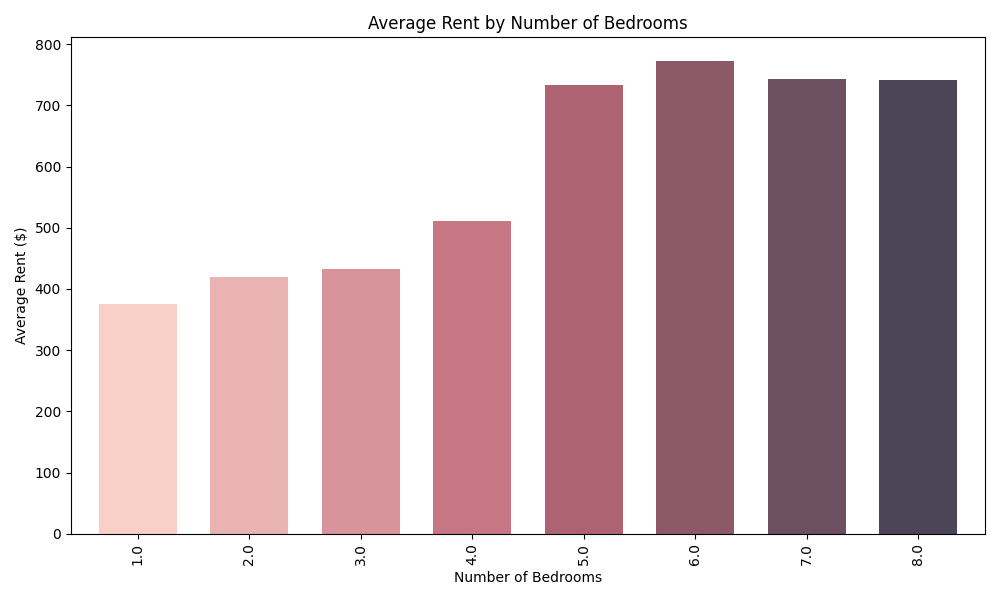

In [23]:
# Load the plot
plot_path = '../plots/avg_rent_bedrooms.png'
plot = Image.open(plot_path)
plot.show()

CBD is known as the home to cultural, sports and festival events. During event period such as Australian Open (Jan), Formula One (Mar), AFL Grand Final (Sep), hotel prices in the CBD generally increase, however, as we can see in the graph below, showcasing the average monthly rental change for all properties in the city area, those events do not play a signifant impact in rent for all property types.

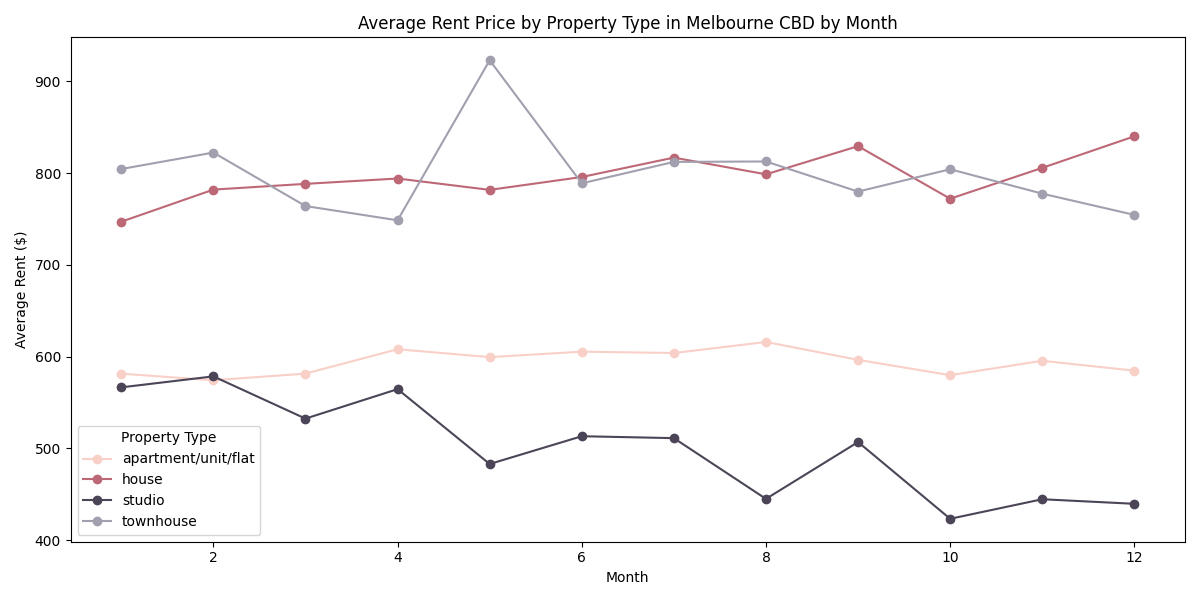

In [24]:
# Load the plot
plot_path = '../plots/avg_rent_by_month_cbd.png'
plot = Image.open(plot_path)
plot.show()

## `Forecasting`

### Our Approach

In our overall approach we decided to use the per property dataset which includes the property listed (from 2015 to 2024) after training and testing multiple models on a per property bases and model with the highest accuracy(XGboost in this case) was used to forcast. For the forcasting the chosen model trained on all the training data to then predict over for 2025 - 2027, the prediction in this case was done over all the training data with the changed year,forcasted population density for the year of prediction and forcasted crime density for the year of prediction taken into account, furthermore after getting the prediction, the predictions were aggregated(mean) by suburbs then the growth was calculated for each suburb using the predicted values of 2025 and 2027 for all the valid suburbs.

(Problems we faced) Due to the imblance of suburbs listing over time, the aggregation(mean) by suburb before predictions would have lost alot of information related to the property, hence we felt would not have been ideal when forcasting over 2025-2027. hence we chose to to predict on a per property bases before aggregating the prediction per suburb to forcast for 2025-2027.


In `Training and testing for all models`, we decided to split our training and testing by time since we wanted to measure the ability of the model to forcast forward based the past historical rent properties, hence before we forcasted the using the models we first used the training(data before 2022) then evaluated it on (the property data after 2022). after that we used metrics such as MSE and R^2 we use the model with the better accuracy to forcast(Asumption: Making the assumption that models that performed better on train and testing data will perform better during forcasting as well...)


`Metrics used`

- we used `R^2` as metric to check how well the model variable explains the variance of the rent, it is used as a goodness of fit measure
- We used `MSE` as metric to check the average error between the predicted and the actual rent values in the testing scenario

(Assumption & limitation & Problem we faced) Since the whole property dataset was used to forcast(with change of the year feature,forcasted population density,forcasted Crime density), we made assumptions that the overall propertions of property type, bedroom and bathrooms would stay the same over the years, since randomising this would have resulted in a loss of information. furthermore since some suburbs did not have lisiting over some years, and there was bias of the number of listings from each susburb, hence this is another reason we used the whole modified dataset for prediction, this resulted in the forcast of all the listings in the suburbs, to be more accurate after aggregations(mean) since we used all the listing per suburbs with modified values.


(Assumptions) We eliminated all the properties, that were in suburbs with less than 40 listings since we felt that would have increased bias,variance, harming our model and forc asting accuracy overall.


all code regarding this is in the `/notebooks/forcastReal.ipynb`

### Ridge Regression 

`Approach and Thinking behind the approach`: We used all the features(categorical and numerical) included in training dataset(2015 - 2022 properties), the use of the penalty term with OLS forces the insignificnant features to have less effect by making their coefficients  go to 0, this decreases overfitting, further more this approach is encouraged where corelation exsists between independent variables(for example the number of bedrooms and the number of bathrooms in property).

`Model assumptions` : their is a need of linearity between dependent and independent variables, also the errors are normally distributed and independent.

`Result`: 


`Mean Squared Error: 42157.704876096075`
`R2 Score: 0.4112123129159442`

this indicates that there is a high error margin, however the R^2 is moderate, there is a lot of room for improvement. this accuracy might be a result of there being high non linearity that 
is not being captured


### Random forrest regression

`Approach and Thinking behind the approach`: We used all the features(categorical and numerical) included in training dataset(2015 - 2022 properties), To capture the nonlinearity we employed the random forrest implementation, which is known to perform better in these situations, further we tuned the parameters by trial and error to fit better parameters for number of trees, depth ensuring there wasnt high depth, as it causes overfitting. all features were used since, random forrest is able to mitigate the effect of less important features, hence feature selection wasnt done.

`Model assumptions` : There are no major model assumptions since random forrest is very flexible

`Result`: 

`Mean Squared Error: 40480.35269041298`
`R2 Score: 0.4346387379724399`

as it can be seen random forrest performs better than ridge regression  in both margin  of error as well as model fit, this might be due to ensemble model explaining non-linearity better. however it can be seen it has a consant bias for predicting the test listings over the years, as its average predicted value is allways below that of the true values. the model took very long to run ,hence there is more room for improvement..

The following visualization helps in understanding that random forrest has clear bias in its predictions

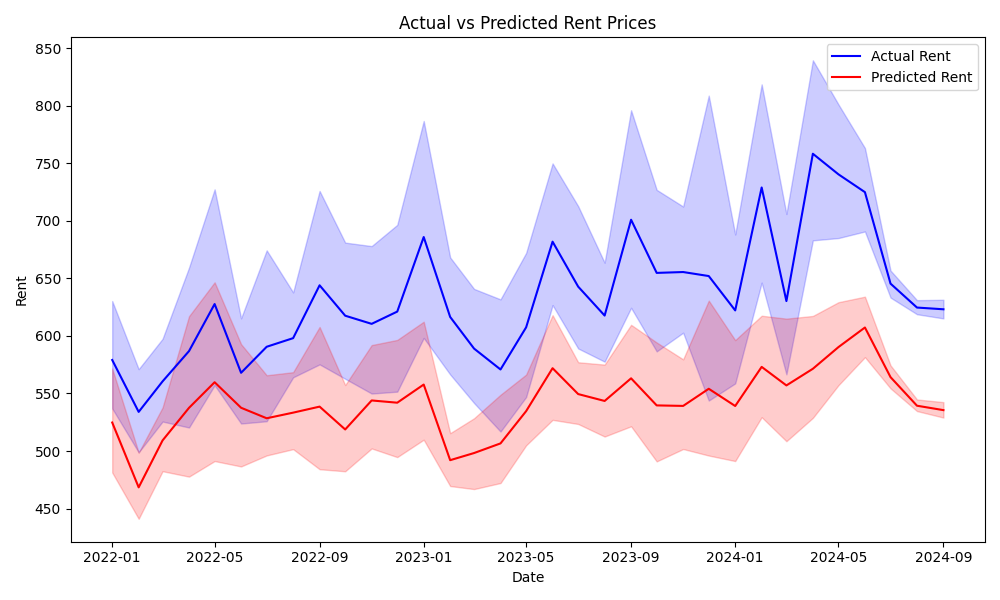

In [21]:
# Load the plot
plot_path = '../plots/model_actual_v_predicted_rf.png'
plot = Image.open(plot_path)
plot.show()

### XGboost 

XGboost is an implemenentation of the gradient boosting framework, like random forrest it is ensemble of descision trees, however each tree that is made is made in a sequential way(which is an improvement compared to random forrest), to correct the errors previous trees, hence we hoped that it would be able to work on bias and improve accuracy

`Approach and Thinking behind the approach`: We used all the features(categorical and numerical) included in training dataset(2015 - 2022 properties), feature selection was n ot needed since XGboost is more likely to use a more important feature when splitting anyways, we did fine tuning for the features such as the number of trees by trial and error, furthermore by ading the L1 and L2 regularisation which penlaizing the inclusion of weak features, hence is used to comboat overfitting, as well.

`Model assumptions` : suffient data, homogeneity variance(not strict), assumption of data points being independent and etc overall XGboost is versitile 

`Result`: 

`Mean Squared Error: 28118.35811248478`
`R2 Score: 0.6072902192776055`

as we can see this model has overall better performance compared to the rest of the models, and the r2 is ~.061 which means it can explain 61% of the variability in rent mening it is an overall good model, we will use this model for forcasting as  it is the best model for prediction of property prices going forward. the bias has also been eliminated as observed below...


The following visualization helps in understanding that XGboost has removed bias in its predictions

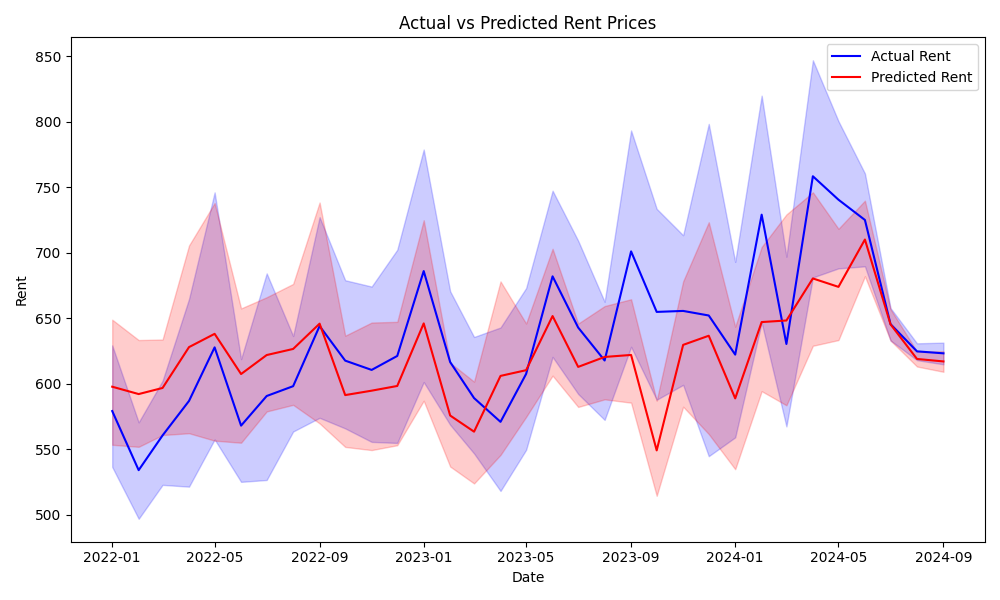

In [20]:
# Load the plot
plot_path = '../plots/model_actual_v_predicted_xgboost.png'
plot = Image.open(plot_path)
plot.show()

### Forcasting results using XGboost

after taking the predictions for 2025 to 2027 per property using XGboost, we aggreagated(mean) over suburbs for each of those years after that we used this approach: 
`(X_mean_rent_2027 - X_mean_rent_2025)/X_mean_rent_2025` where X is a suburb in this case


### Key findings in forcasting

the graphings related to the forcastings can be found in `/notebooks/growth_ranking_edas.ipynb`(it includes maps related to this as well...)

The top ten suburbs with the highest growth rate `fig1`


![top ten](../plots/topten.png)

The most important features used by XGboost to forcast `fig2`

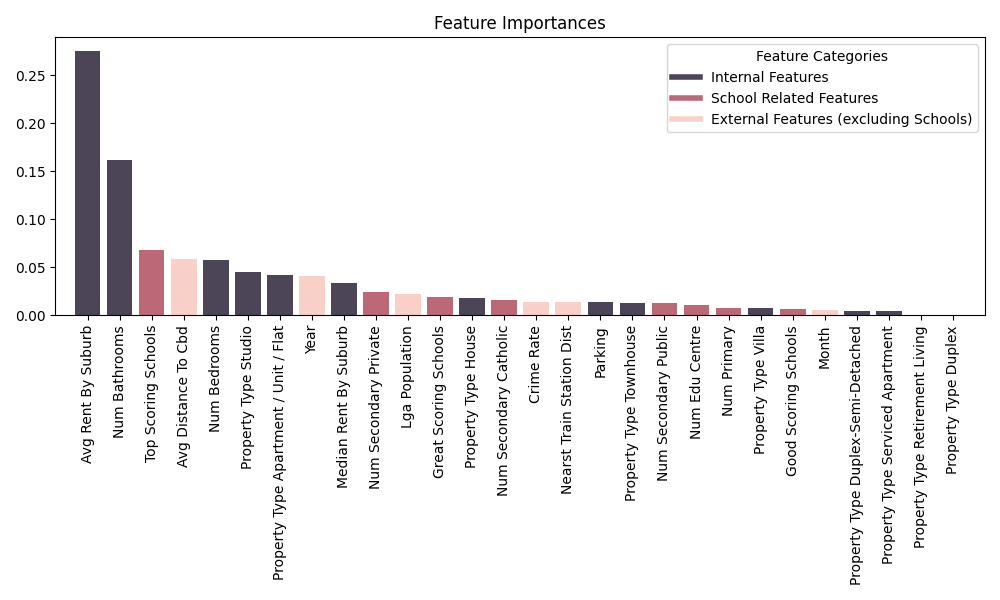

In [19]:
# Load the plot
plot_path = '../plots/feature_importance_all.png'
plot = Image.open(plot_path)
plot.show()

The top ten suburbs with highest average rent  `fig3`

![rent prices of the top ten most expensive](../plots/highestrent.png)

- the `fig1` shows the the suburbs with the highest growth, and a finding is that most of the suburbs with the highest rent tend to be in western victoria and south eastern victoria
- the `fig2` portrays how the most important features in a property for price prediction tend to be average price of rent in  that suburb, wheather there is a high achieving suburb in that area and ect
- the `fig2` portrays the highest rented suburbs, and there average rent prices, an observation is that they are all part of eastern area of melbourne while being close to the city...

further analysis to the forcat is done in `/notebooks/growth_ranking_edas.ipynb`

## `Factors Affecting Rent`

The `fig2` above as shown that the top factors affecting rent are
1. Bathrooms (Internal)
2. Top Schools (External)
3. Distance to CBD (External)
4. Bedrooms (Internal)

When taking a closer look at the shcools factors below, we can see that Top Scoring Schools plays an extremely important role when it comes to relationship with rental prices, whereas Great Scoring Schools fall behind private schools. In additon to the fact that most top scoring schools are private schools, one possible reason could also be due to school zones, hinting the potential insight that private schools do not consist many students living in nearby suburbs, whereas most good scoring schools consist local students who do not need to rent a property.

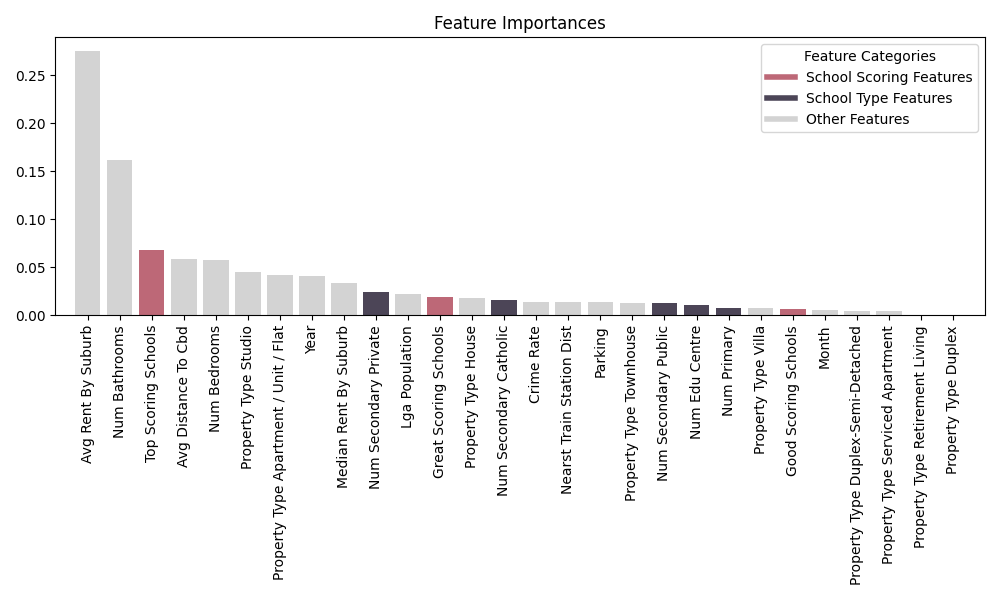

In [26]:
# Load the plot
plot_path = '../plots/feature_importance_schools.png'
plot = Image.open(plot_path)
plot.show()

Looking broader at all external factors below, CBD plays much more important than factors like crime rate & accessibility to train stations, one area to explore is whether this is also correlated with the fact that many top scoring schools like Melbourne Grammar and Melbourne High School are located in the city area. 

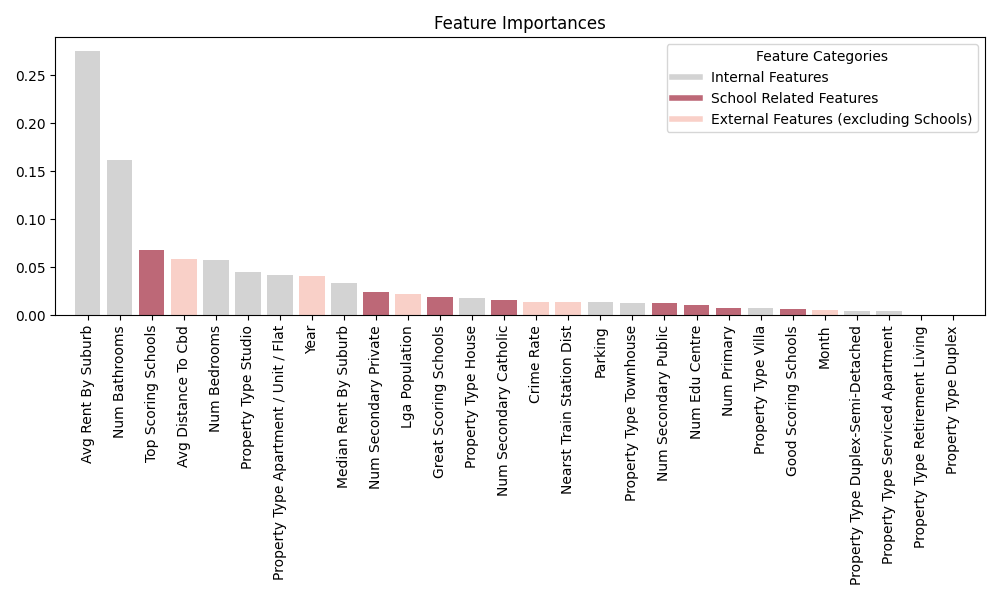

In [27]:
# Load the plot
plot_path = '../plots/feature_importance_external.png'
plot = Image.open(plot_path)
plot.show()

Limitations: 
- Internal factors that were unavailable in the data aquired include property size and property age, which are factors renters would take into consideration when renting a property.
- With enough time and resources, we also wish to refine existing features as well as explore additional external features, such as proximity to facilities like schools, shopping centres, hospitals, as well as refine the proximity calculation using public transport and historical traffic data. 

## `Livability Scoring`
### Our livability scoring is comprised of 9 main metrics and scored for each suburb. 
- Average Rent Price by Number of Bedrooms
- Access to Transportation
- Access to Groceries
- Access to Recreation Facilities
- Access to Medical Facilities
- Access to Community Centers and Libraries
- Access to Education
- Access to Childcare
- Access to Convenience Stores

These amenities were counted per suburb, divided by the population of the suburb, then normalised, with each column representing one of the 9 metrics. With these normalised scores of amenities per population, we came up with weightings for each of the features, and added their scores up to give us and individual score for each suburb as shown below.


### Limitations and Assumptions

We had a few limitations in regards to our livability scoring functions. The main being the reliability of the data used. We sourced most of the data in the amenities from Open Street Map (OSM) and was supplemented with data from external sources, such as Schools ABS data. Additionally, we made assumptions on the importance ratings for each of the features, which both works for and against us. This allows for use to fine tune to each prospector, on which amenities they value more through the adjustment of these weights, which allows for more personalised approach for each client. In the livability_scoring.ipynb notebook, we provide some sample weightings for 3 different demographic groups, such as "Families with Children", "Young working Adults" and "Elderly" populations.

We can solve these issues by delving deeper into current research on urban liveability and potentially, train a model to fine tune parameters based on historical livability rankings for each suburb. Additionally, we can add a few more metrics, regarding employment opportunity, street connectivity and dwelling density, which are other factors that are researched to be integral in scoring liveability. With the help of liveability researchers, we can also create our own metrics such as consideration of Air Quality, Crime Rate, and Traffic Congestion. 

In [5]:
livability_df = pd.read_csv("../data/curated/liveability/output_suburbs_livability_ranked.csv")
livability_df.head(10)

,Suburb,livability_score,Rank
0,Fitzroy,1.019100,1
1,Brunswick,0.995007,2
2,South Yarra,0.992986,3
3,Brighton,0.951841,4
4,Port Melbourne,0.914285,5
5,Glen Waverley,0.888995,6
6,Toorak,0.886675,7
7,Carlton,0.881260,8
8,Northcote,0.874163,9
9,Elwood,0.861627,10


In [6]:
'''figure = Figure()
figure.html.add_child(folium.Html(
    open('../data/curated/liveability/top10_livemap.html').read(),
    script=True
))
display(figure)'''

"figure = Figure()\nfigure.html.add_child(folium.Html(\n    open('../data/curated/liveability/top10_livemap.html').read(),\n    script=True\n))\ndisplay(figure)"

## `Product Prototype`

As most migrants prefer to settle in a community that speaks their language, we used ABS 2021 Census Data to identify the most livable suburb for each language speaking community.

In the example below for Mandarin speakers:
We extract the Mandarin speaking communities then rank using the livability score dataset, and find forecasted rental price using the forecast dataset.

Code in `/notebooks/analysis_suburb_by_lang.ipynb`

One limitation is that for lesser spoken languages in Australia, the metric may not be as relevant as even top ranked suburbs would not have many speakers of that language. Ways forward would be also add a language proportion metric where the client can be informed on how often the language is used in that suburb. What's amazing about the product is its potential to go beyond language, and also able to find livable suburbs for communities like religious communities. 